In [1]:
# ----------------------- #
# Grabbing sources script #
# ----------------------- #
'''
Script to run galaxy source extraction for
deblended SCARLET sources of galaxies. 
'''

# packages and libraries
import scarlet
from lsst.afw.image import MultibandExposure
from lsst.geom import Box2I, Point2I, Extent2I
import lsst.meas.extensions.scarlet as mes
from lsst.daf.butler import Butler
from tqdm.auto import tqdm # comment out for script version of code
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import multiprocessing
from multiprocessing import Process
from multiprocessing import Pool
import os
from time import sleep
import psutil
import pandas as pd

# ---------------------------------------- #
# now grab the sources and store as arrays #
# ---------------------------------------- #
# 3 tracts 9617, 9697, 9813
# 81 patches per tract

REPO = "/projects/HSC/repo/main"                     # Subaru Huper-Suprime Cam catalogue
COLL = "HSC/runs/RC2/w_2022_40/DM-36151"             # current data release

# define function to grab data
def collect_src( patch ):
    
    child_end  = 15                                         # go up to child_end numbers of blended components
    n_child    = 6  #range(1,child_end)                     # number of blended children
    num_child  = 1  #len(n_child)                           # number of blended children vector elements
    skip_count = 0                                          # initialise skip count
    
    # --------------------------------------------------------------- #
    # little rountine to allow collect source                         #
    # to run over all patches in a tract just inputting a             #
    # single integer between 1 and (amount patches) * (amount tracts) #
    # --------------------------------------------------------------- #
    # tract 3 9813
    if (patch > 160):
        tract = 9813
        patch_tmp = patch - 161

    
    # tract 2 9697
    if (patch > 80) and (patch < 161):
        tract = 9697
        patch_tmp = patch - 81
        
    # tract 1 9615    
    if (patch < 81):
        tract = 9615
        patch_tmp = patch
        
    patch = patch_tmp
    
    # Initialise THE BUTLER!!!
    butler = Butler(REPO, collections=[COLL])              # create THE BUTLER
    catalog = butler.get("deepCoadd_deblendedCatalog", tract=tract, patch=patch)
    modelData = butler.get("deepCoadd_scarletModelData", tract=tract, patch=patch)

    # grab the PSF per patch
    observedPSF = [butler.get("deepCoadd_calexp.psf",tract=tract, patch=patch, band=band)
                  for band in modelData.bands]
    
    exposure = [butler.get("deepCoadd_calexp",tract=tract, patch=patch, band=band)
                  for band in modelData.bands]
    
    # ----------------------------------------------- #
    # Loop over full catalogue where num_child is the #
    # length of the vector of deblended children.     #
    # Ie parent ID is sorted by how many children it  #
    # has in the scene so loop over parents with      #
    # 1 child, then 2...etc                           #
    # ----------------------------------------------- #
    for k in range(num_child):

        # grab all instances of  exactly n_child deblended children
        parent = catalog[catalog["deblend_nChild"]== n_child][:]
        src_length = 1 #len( parent ) # set to 1 for testing
        print(f'source number: {src_length}')

        for m in range(src_length):              
            
            # --------------------------------------------------------------- #
            # Using try is handy when running over full dataset as sometimes  #
            # there are no sources with n_child deblended children in a given #
            # patch and I don't want to actually require this. Using try is   #
            # a bit hacky but will work no issue and acts to jump right to    #
            # next patch with no issues.                                      #
            # --------------------------------------------------------------- #
            #try:   # Commented for testing, I want to make sure it works on a single source
                                
                parent_tmp = parent[m]
                parent_ID = parent_tmp.getId()
                blendData = modelData.blends[parent_tmp.getId()]
                bbox = Box2I(Point2I(*blendData.xy0), Extent2I(*blendData.extent))
                
                # things I need for Scarlet models
                nBands = len(modelData.bands)
                blend = mes.io.dataToScarlet(blendData, nBands=nBands)
                
                # get bounding box of full scene
                # not sure if I actually need this as I can just use the scene dims from the cutouts
                footprint = parent_tmp.getFootprint().getBBox().getDimensions()
                box_x = footprint.getX()
                box_y = footprint.getY()
                
                # get cutouts in bands
                cutout_g = exposure[0][bbox]
                cutout_i = exposure[1][bbox]
                cutout_r = exposure[2][bbox]
                cutout_y = exposure[3][bbox]
                cutout_z = exposure[4][bbox]
            
                # grab PSFs
                psf_g = observedPSF[0].computeImage().getArray()
                psf_i = observedPSF[1].computeImage().getArray()
                psf_r = observedPSF[2].computeImage().getArray()
                psf_y = observedPSF[3].computeImage().getArray()
                psf_z = observedPSF[4].computeImage().getArray()
                
                # get masks
                g_mask = cutout_g.mask.getArray()
                i_mask = cutout_i.mask.getArray()
                r_mask = cutout_r.mask.getArray()
                y_mask = cutout_y.mask.getArray()
                z_mask = cutout_z.mask.getArray()
                
                # get variances
                var_g = cutout_g.variance.getArray()
                var_i = cutout_i.variance.getArray()
                var_r = cutout_r.variance.getArray()
                var_y = cutout_y.variance.getArray()
                var_z = cutout_z.variance.getArray()
                
                # grab scene
                g_scene = cutout_g.image.getArray()
                i_scene = cutout_i.image.getArray()
                r_scene = cutout_r.image.getArray()
                y_scene = cutout_y.image.getArray()
                z_scene = cutout_z.image.getArray()
                
                # ---------------------------------------------------- #
                # now we loop over each individual source in the scene #
                # ie there is n_child sources in each scene            #
                # this is just to grab individual scarlet blends       #
                # ---------------------------------------------------- #
                for l in range(n_child):
                    
                    # sepcify single source
                    model = blend.components[l]
                    sources = blend.sources[l]
                    center = sources.center
                    model_bands = sources.get_model()
                    
                    # get scarlet models
                    g_band = model_bands[0]
                    i_band = model_bands[1]
                    r_band = model_bands[2]
                    y_band = model_bands[3]
                    z_band = model_bands[4]

                    # create dictionary
                    src_row = {
                               'parent_ID' : [parent_ID], 
                               'object_num' : [l],
                               'box_x' : [box_x],
                               'box_y' : [box_y],
                               'tract' : [tract],
                               'patch' : [patch],
                               'box_sz': [g_band.shape[1]],
                               'loc'   : [center],
                               'scar_g': [g_band],
                               'scar_i': [i_band],
                               'scar_r': [r_band],
                               'scar_y': [y_band],
                               'scar_z': [z_band],
                               'PSF_g' : [psf_g], 
                               'PSF_i' : [psf_i], 
                               'PSF_r' : [psf_r], 
                               'PSF_y' : [psf_y], 
                               'PSF_z' : [psf_z],
                               'var_g' : [var_g], 
                               'var_i' : [var_i], 
                               'var_r' : [var_r], 
                               'var_y' : [var_y], 
                               'var_z' : [var_z],
                               'mask_g': [g_mask],
                               'mask_i': [i_mask],
                               'mask_r': [r_mask],
                               'mask_y': [y_mask],
                               'mask_z': [z_mask],
                               'scene_g': [g_scene],
                               'scene_i': [i_scene],
                               'scene_r': [r_scene],
                               'scene_y': [y_scene],
                               'scene_z': [z_scene],
                               }
                    
                    cols = ['parent_ID','object_num', 'box_x', 
                            'box_y', 'tract','patch',
                            'box_sz','loc','scar_g','scar_i','scar_r',
                            'scar_y','scar_z','PSF_g', 'PSF_i', 
                            'PSF_r', 'PSF_y', 'PSF_z',
                            'var_g','var_i','var_r', 'var_y', 'var_z',
                            'mask_g', 'mask_i', 'mask_r', 'mask_y', 'mask_z',
                            'scene_g', 'scene_i','scene_r','scene_y','scene_z']
                    
                    # if df exists append to the existing dataframe
                    if 'df' in locals():
                        df_cur = pd.DataFrame(src_row , columns = cols)
                        df = pd.concat([df, df_cur], ignore_index = True)
                    
                    # otherwise, create the dataframe
                    else:
                        df = pd.DataFrame(src_row , columns = cols)

              
            # Un-comment this when try is uncommented, nice
            # to see how many times we skipped a blend                
            #except:
            #    skip_count += 1

    #------------------------------------- #            
    # save the data as a pickled pandas df #
    # ------------------------------------ #
    df.to_pickle("data_test.pkl")
    print('data saved')

In [2]:
# ------------------ #
# collect scene data #
# ------------------ #
# turn off warnings for annoying lsst warning
import warnings
warnings.filterwarnings("ignore")
# testing on a single patch
collect_src(153)

source number: 1
data saved


In [3]:
# Data check
df = pd.read_pickle("data_test.pkl")
print('------------------------')
print(df.info())

------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   parent_ID   6 non-null      int64 
 1   object_num  6 non-null      int64 
 2   box_x       6 non-null      int64 
 3   box_y       6 non-null      int64 
 4   tract       6 non-null      int64 
 5   patch       6 non-null      int64 
 6   box_sz      6 non-null      int64 
 7   loc         6 non-null      object
 8   scar_g      6 non-null      object
 9   scar_i      6 non-null      object
 10  scar_r      6 non-null      object
 11  scar_y      6 non-null      object
 12  scar_z      6 non-null      object
 13  PSF_g       6 non-null      object
 14  PSF_i       6 non-null      object
 15  PSF_r       6 non-null      object
 16  PSF_y       6 non-null      object
 17  PSF_z       6 non-null      object
 18  var_g       6 non-null      object
 19  var_i       6 non-null      o

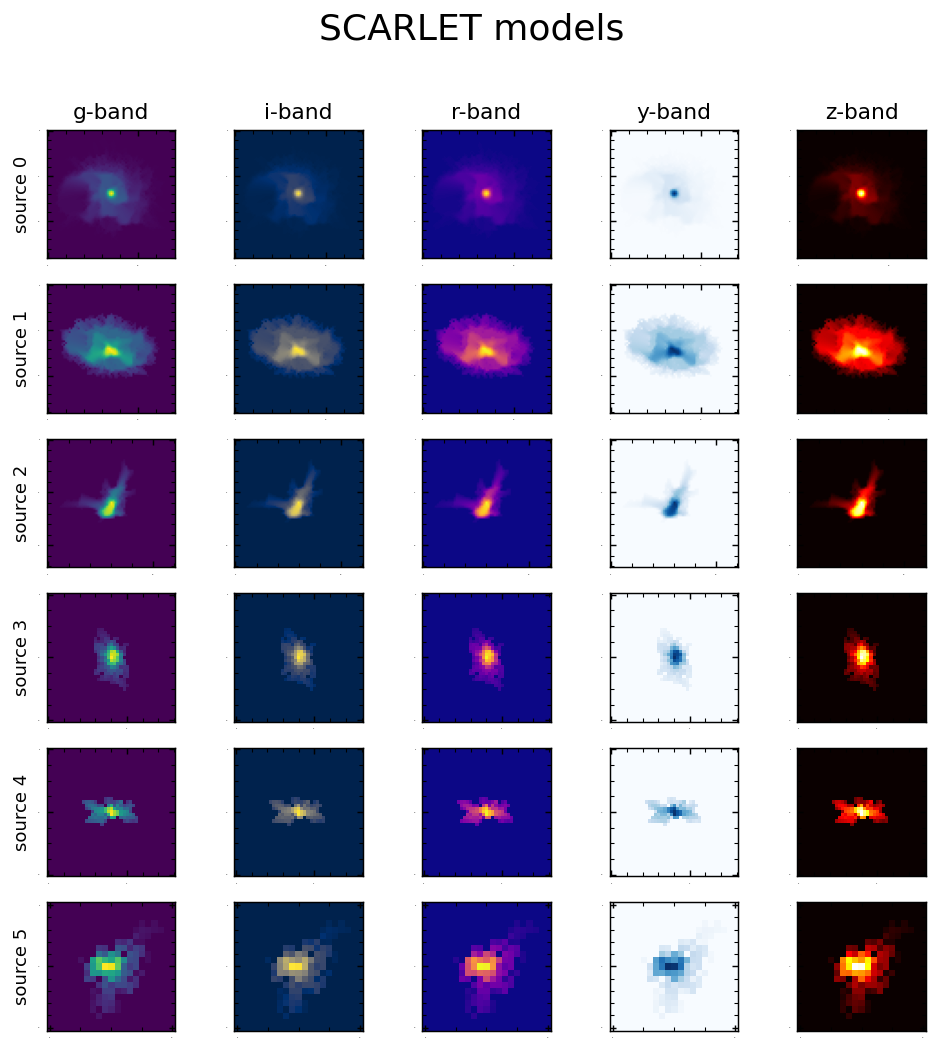

In [4]:
# plot things
import matplotlib as mpl
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True
# ------------------------ #
# check the scarlet models #
# ------------------------ #
fig = plt.figure(figsize=(9, 9), dpi = 130)
n_child = 6

for i in range(n_child):
    plt.subplot(n_child,5,i*5 + 1)
    plt.imshow(df['scar_g'][i])
    if(i == 0): plt.title('g-band')
    name = 'source ' + str(df['object_num'][i])
    plt.ylabel(name)
    plt.xticks(fontsize=0)
    plt.yticks(fontsize=0)

    plt.subplot(n_child,5,i*5 + 2)
    plt.imshow(df['scar_i'][i], cmap = 'cividis')
    if(i == 0): plt.title('i-band')
    plt.xticks(fontsize=0)
    plt.yticks(fontsize=0)

    plt.subplot(n_child,5,i*5 + 3)
    plt.imshow(df['scar_r'][i], cmap = 'plasma')
    if(i == 0): plt.title('r-band')
    plt.xticks(fontsize=0)
    plt.yticks(fontsize=0)

    plt.subplot(n_child,5,i*5 + 4)
    plt.imshow(df['scar_y'][i], cmap = 'Blues')
    if(i == 0): plt.title('y-band')
    plt.xticks(fontsize=0)
    plt.yticks(fontsize=0)

    plt.subplot(n_child,5,i*5 + 5)
    plt.imshow(df['scar_z'][i], cmap = 'hot')
    if(i == 0): plt.title('z-band')
    plt.xticks(fontsize=0)
    plt.yticks(fontsize=0)

plt.suptitle('SCARLET models',fontsize=20)    
plt.show()


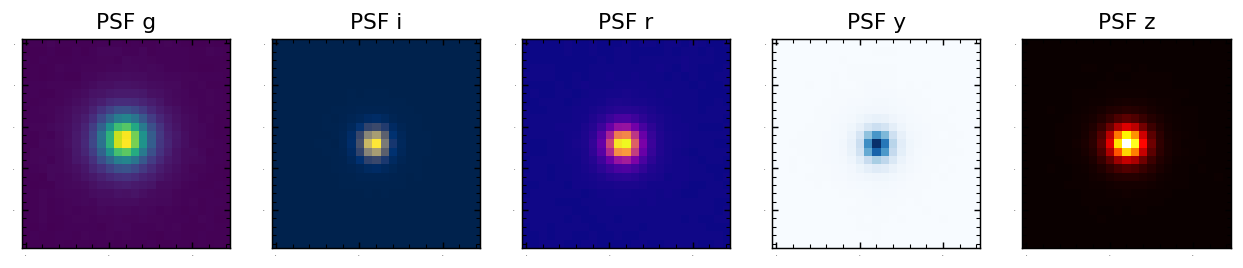

In [5]:
# -------------- #
# check the PSFs #
# -------------- #
fig = plt.figure(figsize=(12, 6), dpi = 130)
plt.subplot(1,5,1)
plt.imshow(df['PSF_g'][0])
plt.title('PSF g')
plt.xticks(fontsize=0)
plt.yticks(fontsize=0)

plt.subplot(1,5,2)
plt.imshow(df['PSF_i'][0], cmap = 'cividis')
plt.title('PSF i')
plt.xticks(fontsize=0)
plt.yticks(fontsize=0)

plt.subplot(1,5,3)
plt.imshow(df['PSF_r'][0], cmap = 'plasma')
plt.title('PSF r')
plt.xticks(fontsize=0)
plt.yticks(fontsize=0)

plt.subplot(1,5,4)
plt.imshow(df['PSF_y'][0], cmap = 'Blues')
plt.title('PSF y')
plt.xticks(fontsize=0)
plt.yticks(fontsize=0)

plt.subplot(1,5,5)
plt.imshow(df['PSF_z'][0], cmap = 'hot')
plt.title('PSF z')
plt.xticks(fontsize=0)
plt.yticks(fontsize=0)
    
plt.show()

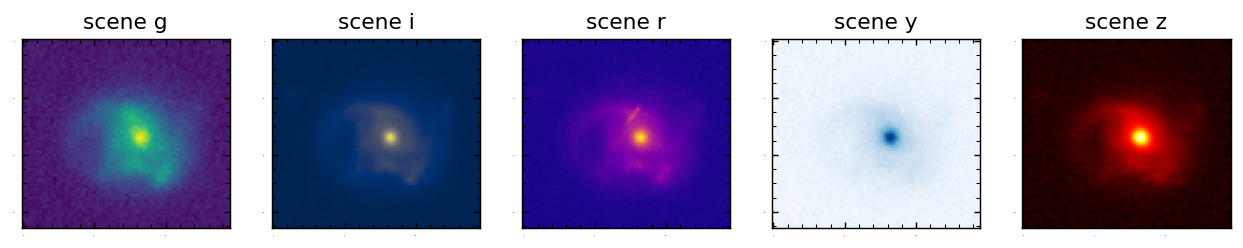

In [6]:
# -------------------- #
# check the full scene #
# -------------------- #
fig = plt.figure(figsize=(12, 6), dpi = 130)
plt.subplot(1,5,1)
plt.imshow(df['scene_g'][0])
plt.title('scene g')
plt.xticks(fontsize=0)
plt.yticks(fontsize=0)

plt.subplot(1,5,2)
plt.imshow(df['scene_i'][0], cmap = 'cividis')
plt.title('scene i')
plt.xticks(fontsize=0)
plt.yticks(fontsize=0)

plt.subplot(1,5,3)
plt.imshow(df['scene_r'][0], cmap = 'plasma')
plt.title('scene r')
plt.xticks(fontsize=0)
plt.yticks(fontsize=0)

plt.subplot(1,5,4)
plt.imshow(df['scene_y'][0], cmap = 'Blues')
plt.title('scene y')
plt.xticks(fontsize=0)
plt.yticks(fontsize=0)

plt.subplot(1,5,5)
plt.imshow(df['scene_z'][0], cmap = 'hot')
plt.title('scene z')
plt.xticks(fontsize=0)
plt.yticks(fontsize=0)
    
plt.show()

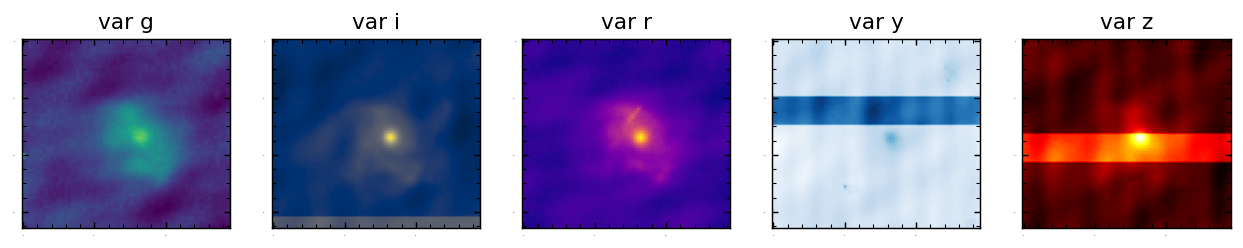

In [7]:
# ------------------- #
# check the variances #
# ------------------- #
fig = plt.figure(figsize=(12, 6), dpi = 130)
plt.subplot(1,5,1)
plt.imshow(df['var_g'][0])
plt.title('var g')
plt.xticks(fontsize=0)
plt.yticks(fontsize=0)

plt.subplot(1,5,2)
plt.imshow(df['var_i'][0], cmap = 'cividis')
plt.title('var i')
plt.xticks(fontsize=0)
plt.yticks(fontsize=0)

plt.subplot(1,5,3)
plt.imshow(df['var_r'][0], cmap = 'plasma')
plt.title('var r')
plt.xticks(fontsize=0)
plt.yticks(fontsize=0)

plt.subplot(1,5,4)
plt.imshow(df['var_y'][0], cmap = 'Blues')
plt.title('var y')
plt.xticks(fontsize=0)
plt.yticks(fontsize=0)

plt.subplot(1,5,5)
plt.imshow(df['var_z'][0], cmap = 'hot')
plt.title('var z')
plt.xticks(fontsize=0)
plt.yticks(fontsize=0)
    
plt.show()

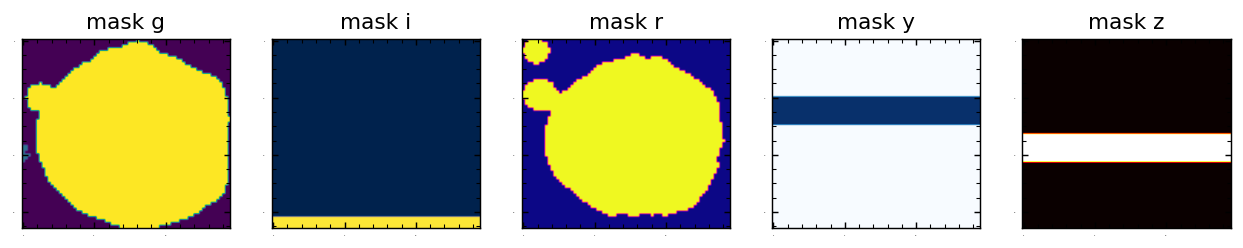

In [8]:
# --------------- #
# check the masks #
# --------------- #
fig = plt.figure(figsize=(12, 6), dpi = 130)
plt.subplot(1,5,1)
plt.imshow(df['mask_g'][0])
plt.title('mask g')
plt.xticks(fontsize=0)
plt.yticks(fontsize=0)

plt.subplot(1,5,2)
plt.imshow(df['mask_i'][0], cmap = 'cividis')
plt.title('mask i')
plt.xticks(fontsize=0)
plt.yticks(fontsize=0)

plt.subplot(1,5,3)
plt.imshow(df['mask_r'][0], cmap = 'plasma')
plt.title('mask r')
plt.xticks(fontsize=0)
plt.yticks(fontsize=0)

plt.subplot(1,5,4)
plt.imshow(df['mask_y'][0], cmap = 'Blues')
plt.title('mask y')
plt.xticks(fontsize=0)
plt.yticks(fontsize=0)

plt.subplot(1,5,5)
plt.imshow(df['mask_z'][0], cmap = 'hot')
plt.title('mask z')
plt.xticks(fontsize=0)
plt.yticks(fontsize=0)
    
plt.show()

In [9]:
import lsst.meas.extensions.scarlet as mes

tract = df['tract'][0]
patch = df['patch'][0]

butler = Butler(REPO, collections=[COLL])              # create THE BUTLER
catalog = butler.get("deepCoadd_deblendedCatalog", tract=tract, patch=patch)
modelData = butler.get("deepCoadd_scarletModelData", tract=tract, patch=patch)

# Select the first record with exactly 7 deblended children
parent = catalog[catalog["deblend_nChild"]== n_child][0]
# Load the PSF for the observation in each band
observedPsfs = [
    butler.get("deepCoadd_calexp.psf", tract=tract, patch=patch, band=band)
    for band in modelData.bands
]

# Extract the scarlet LiteBlend from the ScarletModelData
blend = mes.io.multibandDataToScarlet(
    modelData=modelData,
    blendId=parent.getId(),
    observedPsfs=observedPsfs
)



from lsst.afw.image import MultibandExposure
from lsst.geom import Box2I, Point2I, Extent2I
# Extract the bounding box for the blend
blendData = modelData.blends[parent.getId()]
bbox = Box2I(Point2I(*blendData.xy0), Extent2I(*blendData.extent))
# Load the Exposure in each band
mExposure = MultibandExposure.fromButler(
    butler,
    modelData.bands,
    "deepCoadd_calexp",
    parameters={"bbox": bbox},
    tract=tract,
    patch=patch
)

# Extract the scarlet LiteBlend from the ScarletModelData
blend = mes.io.multibandDataToScarlet(
    modelData=modelData,
    blendId=parent.getId(),
    mExposure=mExposure,
    footprint=parent.getFootprint()
)

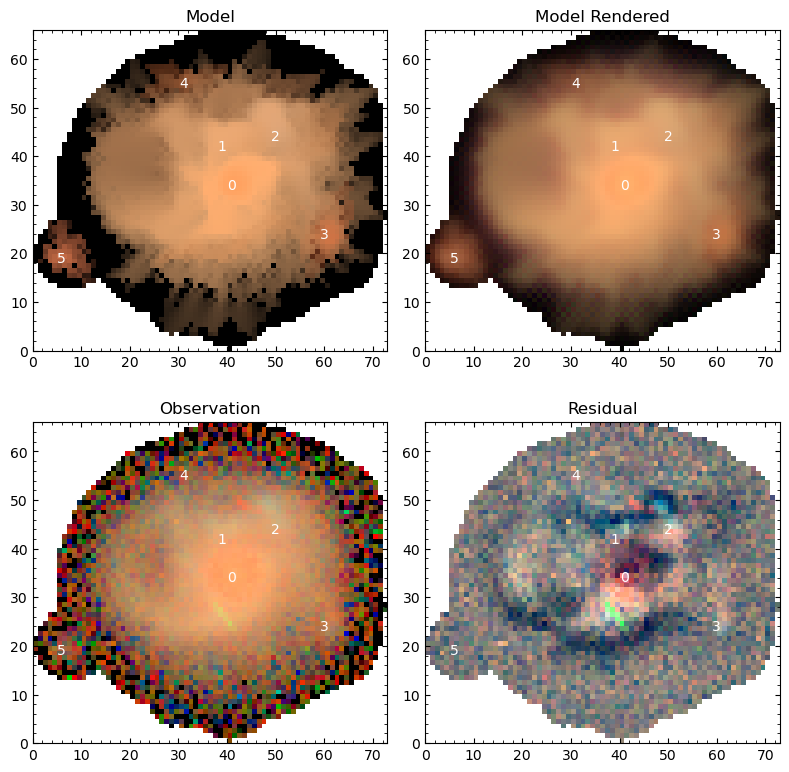

In [10]:
# Use the Lupton RGB sinh^-1 mapping to preserve colors
norm = scarlet.display.AsinhMapping(minimum=0, stretch=0.1, Q=10)
# Hide the narrow-band filter
channelMap = np.zeros((3, 6))
channelMap[:, 1:] = scarlet.display.channels_to_rgb(5)
channelMap

# Display the scene
scarlet.lite.display.show_scene(
    blend,
    norm=norm,
    show_model=True,
    show_rendered=True,
    show_observed=True,
    show_residual=True,
    linear=False,
    figsize=(8, 8),
)
plt.show()